## Get Data Ready

In [26]:
!pip3 install alpha_vantage

In [2]:
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn-white')
import os
import scipy
from scipy import optimize
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# Register online ane replace with your key
MY_API_KEY = ""

ONEYEARDAYS = 252
outputsize = (14,12)
output_dpi = 200

In [3]:
ts = TimeSeries(key='MY_API_KEY', output_format='pandas')

def get_daily_price(symbol, for_cov = False):
    ## Fetch daily close price
    full_data, meta_data = ts.get_daily(symbol = symbol, outputsize='full')
    full_data = full_data[::-1]
    series_index = pd.Series(full_data.index)
    full_data.index = series_index.apply(lambda t: np.datetime64(t).astype(datetime).date()).values
    assert '4. close' in full_data.columns
    close = full_data['4. close']
    close.index.name = 'Date'
    close.name = symbol
    
    assert close.index[0] < datetime(2005,1,3).date()
    if for_cov:
        return close[datetime(2005,1,3).date() : ]
    else:
        return close[datetime(2006,1,3).date() : ]

SPY = get_daily_price('SPY')
AGG = get_daily_price('AGG')
GLD = get_daily_price('GLD')
mergeStep1 = pd.merge(left = SPY, left_index = True, right = AGG, right_index=True, how = 'inner')
dataall = pd.merge(left = mergeStep1, left_index = True, right = GLD, right_index=True, how = 'inner')

## Asset Performance

Text(0.5, 1.0, 'GLD')

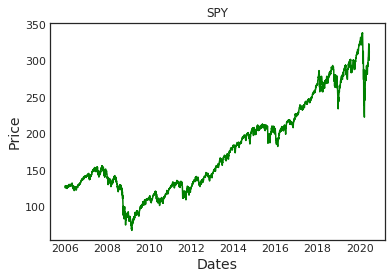

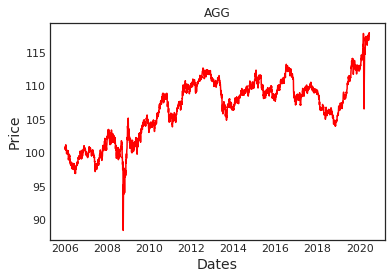

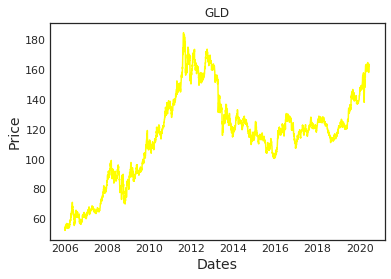

In [4]:

fig,ax = plt.subplots()
ax.plot(SPY, color = 'green')
ax.set_xlabel('Dates',fontsize=14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('SPY')
##########################
fig,ax = plt.subplots()
ax.plot(AGG, color = 'red')
ax.set_xlabel('Dates',fontsize =14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('AGG')
##########################
fig,ax = plt.subplots()
ax.plot(GLD, color ='yellow')
ax.set_xlabel('Dates',fontsize =14)
ax.set_ylabel('Price',fontsize =14)
ax.set_title('GLD')

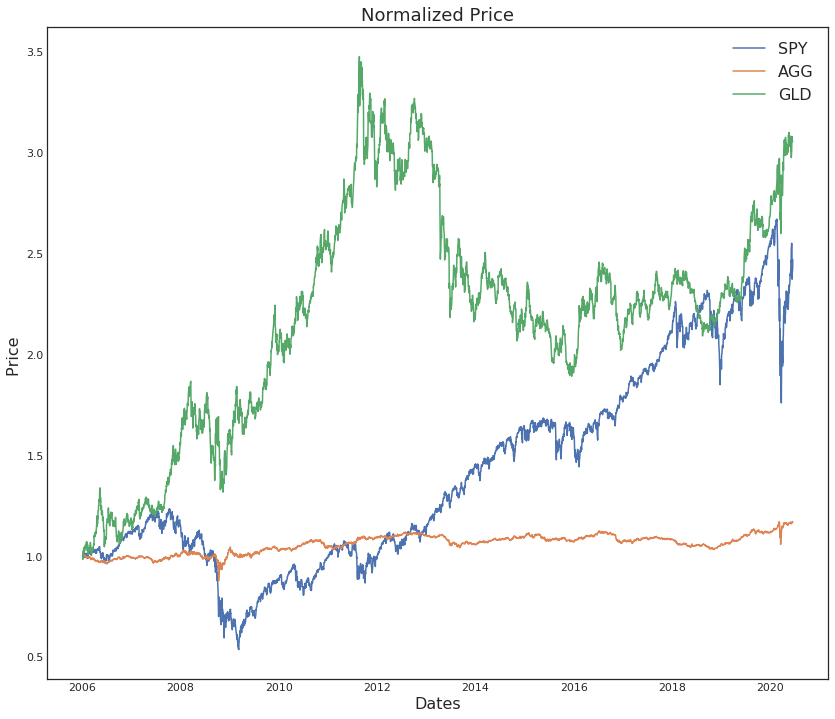

In [5]:
normalized_price = (dataall/dataall.iloc[0])
fig =plt.figure(figsize=outputsize)
plt.plot(normalized_price)
title_text_obj = plt.title("Normalized Price", fontsize = 18)
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Price ', fontsize = 16)
plt.legend(('SPY','AGG','GLD'),fontsize = 16,loc = 'best')
plt.show()

### Return Series

In [6]:
## Thinking: How to calculate return?
## 1 or -1?
returns = dataall.pct_change(1)
returns.dropna(inplace = True)

## Daily price changing ratio
returns_mul_factor = returns + 1

spy_ret = returns['SPY']
agg_ret = returns['AGG']
gld_ret = returns['GLD']

day_counts = len(spy_ret)
calendar = returns.index.values

## Days and calenar
day_counts = len(spy_ret)
calendar = returns.index.values

### Historical Correlation

In [7]:
np.round(returns.corr(),2)

,SPY,AGG,GLD
SPY,1.00,-0.08,0.03
AGG,-0.08,1.00,0.17
GLD,0.03,0.17,1.00


### Return distribution 

In [8]:
stats = pd.DataFrame()
stats['Annualized Returns(%)']    = np.round(returns.mean() * ONEYEARDAYS *100,2)
stats['Annualized Volatility(%)'] = np.round(returns.std() * np.sqrt(ONEYEARDAYS)*100,2)
stats['Sharpe Ratio'] = np.round(stats['Annualized Returns(%)'] /stats['Annualized Volatility(%)'],2)
stats.style.bar(color=['red','green'], align='zero')

,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
SPY,8.310000,20.210000,0.410000
AGG,1.220000,5.210000,0.230000
GLD,9.470000,18.590000,0.510000


***Basic risk measure for return distribution:***

  $Skewness = E\left[\left(\frac{X -\mu}{\sigma(X)}\right)^3\right]$
  
  $Kurtosis = E\left[\left(\frac{X -\mu}{\sigma(X)}\right)^4\right]$

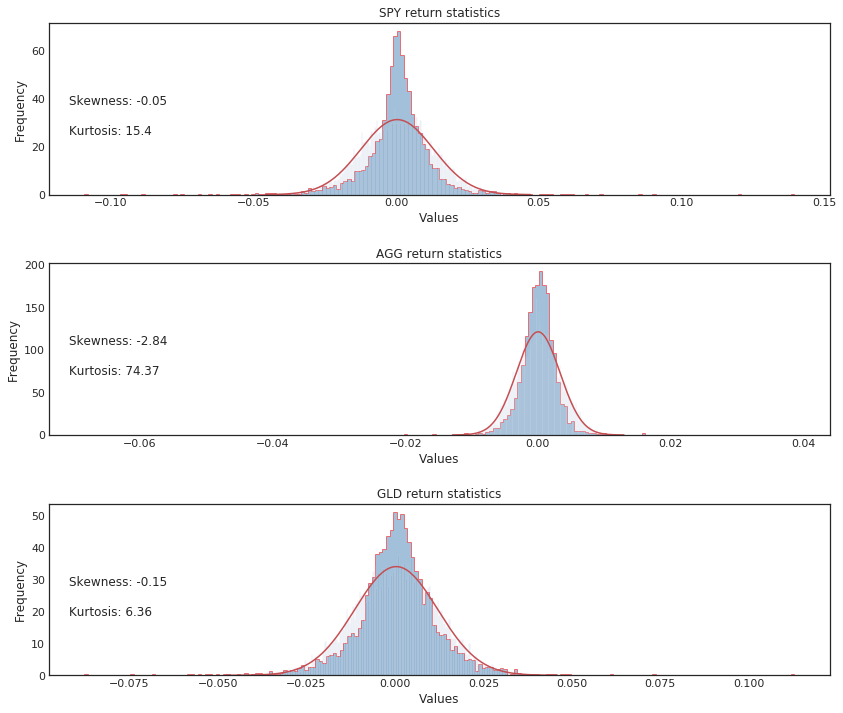

In [9]:
binsnumber = 200
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=outputsize)
plt.subplots_adjust(hspace=.4,wspace=.4) # it adds space in between plots

plt.subplot(311)
ax = plt.gca()
ax.hist(returns['SPY'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['SPY'].std(),returns['SPY'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['SPY'].skew(),2),
                                                  round(returns['SPY'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('SPY return statistics')


#####################
plt.subplot(312)
ax = plt.gca()

ax.hist(returns['AGG'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['AGG'].std(),returns['AGG'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['AGG'].skew(),2),
                                                  round(returns['AGG'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('AGG return statistics')


#####################
plt.subplot(313)
ax = plt.gca()

ax.hist(returns['GLD'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = returns['GLD'].std(),returns['GLD'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(returns['GLD'].skew(),2),
                                                  round(returns['GLD'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,60),fontsize=12)

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('GLD return statistics')

plt.show();

## Risk Parity:
***Reference to Risk Parity @BridgeWater***   https://www.bridgewater.com/resources/risk-parity-is-about-balance.pdf

***Risk Parity @PanAgora***  https://www.panagora.com/assets/PanAgora-Risk-Parity-Portfolios-Efficient-Portfolios-Through-True-Diversification.pdf


Portfolio Return:

$$ r_p = \sum_{i}^{N}x_{i}r_{i}, \sigma_{p} = \sqrt{\sum_{i}^{N}\sum_{j}^{N}x_{i}x_{j}\sigma_{ij}}$$

Marginal Risk Contribution (MRC):
$$MRC_{i} = \frac{\partial{\sigma_p}}{\partial{x_i}} = \sum_{i}^{N} \frac{x_i\sigma_{ij}}{\sigma_p} = cov(r_i, r_p)/\sigma_p$$

Marginal Risk Contribution shows the increase of portfolio risk when we increase a unit of the asset $x_i$, so we can get the Total Risk Contribution (TRC)

$$TRC_i = x_i \frac{\partial{\sigma_p}}{\partial{x_i}} = \sum_{i}^{N} x_i x_j \sigma_{ij}/ \sigma_p  = x_i cov(r_i, r_p)/ \sigma_p$$

If we sum up all the Total Risk Contribution of asset $x_i$ we got :
$$ \sum_{i}^{N} TRC_i = \sum_{i}^{N} x_i cov(r_i, r_p) = \sigma_p$$

If we need to allocate risk equally, we need to make sure 
$$ x_i \frac{\partial{\sigma_p}}{\partial{x_i}} = x_j \frac{\partial{\sigma_p}}{\partial{x_j}} = \lambda, \forall i,j$$

In realistic numerical optimization, we can solve like this:
$$ min \sum_{i}^{N}\sum_{j}^{N}(TRC_i - TRC_j)^2$$
$$ s.t. \sum_{i}^{N} x_i = 1$$

In [10]:
def equal_risk(weight, cov):
    TRC1 = weight[0]**2 * cov.iloc[0, 0] + \
        weight[0]*weight[1] * cov.iloc[1,0] + \
        weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[2,0]
        
    TRC2 = weight[0]*weight[1] * cov.iloc[0,1] + \
        weight[1]**2 * cov.iloc[1,1] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[2,1]
        
    TRC3 = weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[0,2] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[1,2] + \
        (1 - weight[0] - weight[1])**2 * cov.iloc[2,2]
        
    return np.square(TRC1 - TRC2)+ np.square(TRC2 - TRC3) + np.square(TRC1 - TRC3)

def TRC(weight,cov):
    """
    Total Risk Contribution
    """
    totalRiskContribution_1 = weight[0]**2 * cov.iloc[0, 0] + \
        weight[0]*weight[1] * cov.iloc[1,0] + \
        weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[2,0]
        
    totalRiskContribution_2 = weight[0]*weight[1] * cov.iloc[0,1] + \
        weight[1]**2 * cov.iloc[1,1] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[2,1]
        
    totalRiskContribution_3 = weight[0]*(1 - weight[0] - weight[1]) * cov.iloc[0,2] + \
        weight[1]*(1 - weight[0] - weight[1]) * cov.iloc[1,2] + \
        (1 - weight[0] - weight[1])**2 * cov.iloc[2,2]
    
    variance_Portfolio = np.dot(np.dot(weight, cov), weight.T)
    
    return np.array([totalRiskContribution_1, totalRiskContribution_2, totalRiskContribution_3])/variance_Portfolio
    
def weight_calculation(cov_df):
    ans = minimize(equal_risk, [0.3, 0.3], (cov_df), method='L-BFGS-B',  bounds=((0,1), (0,1)))
    result = []
    result.extend(list(ans.x))
    result.append(1- ans.x.sum())
    return np.array(result)

In [12]:
## For calculating covariance, need more historical data
cSPY = get_daily_price('SPY', for_cov=True)
cAGG = get_daily_price('AGG', for_cov=True)
cGLD = get_daily_price('GLD', for_cov=True)
mergeLeft = pd.merge(left = cSPY, left_index = True, right = cAGG, right_index=True, how = 'inner')
dataall_c = pd.merge(left = mergeLeft, left_index = True, right = cGLD, right_index=True, how = 'inner')
returns_c = dataall_c.pct_change()
returns_c.dropna(inplace = True)

## Backtest Analysis

In [13]:
def Backtest(cov_frequency, rebalance_frequency, method, get_records = False, FEE = 0.0005):
    
    ## Calculating covariance matrix
    ONEYEARDAYS = 252
    cov_series = returns_c.rolling(window = cov_frequency).cov() * ONEYEARDAYS
  
  
    if method == "Equal Risk":
        
        rebalance_cov = [] ## [{date : covariance},...]
        rebalance_times = day_counts//rebalance_frequency

        for i in range(1, rebalance_times + 1):
            ## Indexing the covariance matrix, in pair of (date, covariance matrix)
            date = calendar[rebalance_frequency * i  - 1]
            rebalance_cov.append((date,cov_series.loc[date]))   
        
        ## Get rebalancing date and weight
        rebalance_pair = {} ## {date : weight}
        for i in range(len(rebalance_cov)):
            res = weight_calculation(rebalance_cov[i][1])
            rebalance_pair.update({rebalance_cov[i][0] : res})

        rebalance_pair = pd.Series(rebalance_pair)
        rebalance_date = rebalance_pair.index.values
        rebalance_weight = rebalance_pair.values
        new_calendar = calendar[calendar > rebalance_date[0]]
        
        cov_pair = {}  ## {date : covariance}
        for date in new_calendar:
            cov_pair.update({date : cov_series.loc[date]})
     
        ## backtest equal risk result
        backtest_result = {}
        risk_contribution = pd.DataFrame()
        backtest_weight = pd.DataFrame()

        current_asset = rebalance_weight[0] * 1000
        current_weight = rebalance_weight[0]
        backtest_weight.update({rebalance_date[0] : current_weight})
        current_cov = cov_pair.get(rebalance_date[0])
        ## Invest 1000 unit at the first day
        backtest_result.update({rebalance_date[0] : 1000})
            
        for date in new_calendar:

            if date not in rebalance_date:
                ## at the end of day, market closed (we use close level to calculate return)
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                current_weight = current_asset / current_level
                backtest_weight[date] = current_weight
                backtest_result.update({date: current_level})
                current_cov = cov_pair.get(date)
                risk_contribution[date] = TRC(current_weight, current_cov)
                
            elif date in rebalance_date:
                ## at rebalance day, we hold till market close, get rolling covariance matrix, then rebalance
                ## Forward bias: rebalance should be done before market close, 
                ## while we calculate our rebalance weight using the close level of that day. 
                ## If market has no big move near close it's OK.
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                ## Get new rebalance weight, deduct general fee
                previous_asset = current_asset
                current_asset = rebalance_pair.get(date) * current_level
                current_asset -= np.abs(previous_asset - current_asset) * FEE
                current_level -= (np.abs(previous_asset - current_asset) * FEE).sum() 
                backtest_result.update({date: current_level})
                ## Calculate Total Risk Contribution
                current_weight = rebalance_pair.get(date)
                backtest_weight[date] = current_weight
                current_cov = cov_pair.get(date) ## Covariance based on close of the rebalance day
                risk_contribution[date] = TRC(current_weight, current_cov)
                
        backtest_result = pd.Series(backtest_result) 
        risk_contribution = risk_contribution.T
        risk_contribution.columns = ['SPY','AGG','GLD']
        backtest_weight = backtest_weight.T
        backtest_weight.columns = ['SPY','AGG','GLD']
        backtest_weight.index.name = 'Date'
        backtest_result.index.name = 'Date'
        risk_contribution.index.name = 'Date'
        
        if get_records == True:
            return backtest_result, risk_contribution, backtest_weight
        else:
            return backtest_result
        
    elif method == "Equal Capital":
        ## Get rebalancing date and weight
        rebalance_times = day_counts//rebalance_frequency
        rebalance_date = []
        
        for i in range(1, rebalance_times + 1):  
            date = calendar[rebalance_frequency * i  - 1]
            rebalance_date.append(date)
        
        new_calendar = calendar[calendar > rebalance_date[0]]
        
        cov_pair = {}  ## {date : covariance}
        for date in new_calendar:
            cov_pair.update({date : cov_series.loc[date]})
            
        ## backtest equal capital result
        backtest_result = {}
        risk_contribution = pd.DataFrame()
        backtest_weight = pd.DataFrame()
        
        equal_capital_weight = np.array([1,1,1])/3
        current_asset = equal_capital_weight * 1000
        backtest_weight.update({rebalance_date[0] : equal_capital_weight})
        current_cov = cov_pair.get(rebalance_date[0])
        ## Invest 1000 unit at the first day
        backtest_result.update({rebalance_date[0] : 1000})

        for date in new_calendar:

            if date not in rebalance_date:
                ## at the end of day, market closed (we use close level to calculate return)
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                current_weight = current_asset / current_level
                backtest_weight[date] = current_weight
                backtest_result.update({date: current_level})
                current_cov = cov_pair.get(date)
                risk_contribution[date] =  TRC(current_weight, current_cov)
                
            elif date in rebalance_date:
                 ## at rebalance day, we hold till market close, get rolling covariance matrix, then rebalance with equal capital
                current_asset = current_asset * (returns_mul_factor.loc[date].values)
                current_level = current_asset.sum()
                ## Get new rebalance weight
                previous_asset = current_asset
                current_asset = equal_capital_weight * current_level
                current_asset -= np.abs(previous_asset - current_asset) * FEE
                current_level -= (np.abs(previous_asset - current_asset) * FEE).sum()
                current_weight = equal_capital_weight
                backtest_result.update({date: current_level})
                backtest_weight[date] = equal_capital_weight
                ## Calculate Total Risk Contribution
                current_cov = cov_pair.get(date) ## Covariance based on close of the rebalance day
                risk_contribution[date] = TRC(current_weight, current_cov)

        backtest_result = pd.Series(backtest_result)
        
        risk_contribution = risk_contribution.T
        risk_contribution.columns = ['SPY','AGG','GLD']
        risk_contribution.index.name = 'Date'

        backtest_weight = backtest_weight.T
        backtest_weight.columns = ['SPY','AGG','GLD']
        backtest_weight.index.name = 'Date'
        backtest_result.index.name = 'Date'
        
        
        if get_records == True:
            return backtest_result, risk_contribution, backtest_weight
        else:
            return backtest_result
        

In [14]:

def MaxDD(result, get_pair = False):
    i = np.argmax(np.maximum.accumulate(result) - result) # end of the period
    j = np.argmax(result[:i]) # start of period
    if get_pair == False:
        return np.round((result[i] - result[j])/result[j] * 100,2)
    else:
        return (j,i)
    
def performance_analysis(backtest_result):
    strategy_return = backtest_result.pct_change().dropna()
    strategy_stats = pd.DataFrame()
    ##Compound Annual Growth Rate
    N = len(backtest_result)/ONEYEARDAYS
    strategy_stats['CAGR(%)'] = np.round((np.power(backtest_result.iloc[-1]/backtest_result.iloc[0],1/N) - 1)*100,2)
    strategy_stats['Annualized Returns(%)'] = np.round(strategy_return.mean() * ONEYEARDAYS *100,2)
    strategy_stats['Annualized Volatility(%)'] = np.round(strategy_return.std() * np.sqrt(ONEYEARDAYS)*100,2)
    strategy_stats['Sharpe Ratio'] = np.round(strategy_stats['Annualized Returns(%)'] /strategy_stats['Annualized Volatility(%)'],2)
    
    mdd = {}
    for colName in backtest_result.columns:
        mdd.update({colName : MaxDD(backtest_result[colName].values)})
    
    strategy_stats['MaxDD (%)'] = pd.Series(mdd) 
       
    return strategy_stats

In [15]:
backtest_result = pd.DataFrame()
backtest_result['Equal Capital'] = Backtest(cov_frequency=30, rebalance_frequency=30,
                                            method = "Equal Capital",get_records=False)
backtest_result['Equal Risk'] = Backtest(cov_frequency=30, rebalance_frequency=30, 
                                         method = "Equal Risk",get_records=False)
strategy_return = backtest_result.pct_change().dropna()
strategy_return;

In [16]:
all_result = pd.merge(left= backtest_result, left_index = True, right=dataall, right_index = True, how = 'inner' )
strategy_stats = performance_analysis(backtest_result=all_result)
# print('Strategy Performance Annualized Statistics - full observation period')
strategy_stats.style.bar(color=['red','green'], align='zero')

,CAGR(%),Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,MaxDD (%)
Equal Capital,5.790000,6.070000,9.430000,0.640000,-15.390000
Equal Risk,4.040000,4.160000,6.310000,0.660000,-13.270000
SPY,6.430000,8.290000,20.280000,0.410000,-34.100000
AGG,1.150000,1.280000,5.230000,0.240000,-14.600000
GLD,8.020000,9.440000,18.550000,0.510000,-45.560000


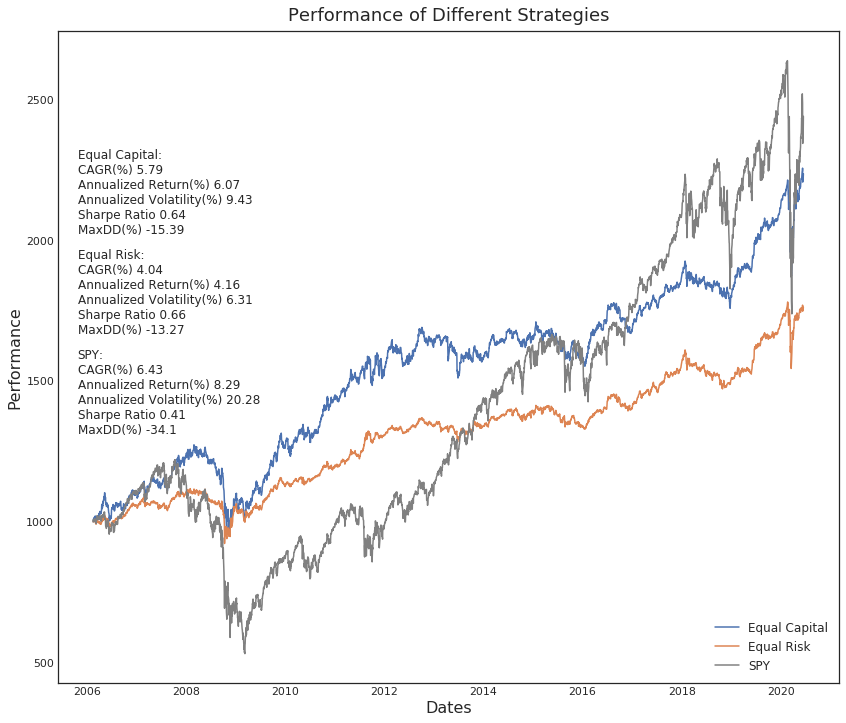

In [21]:
fig =plt.figure(figsize=outputsize)
ax = plt.gca()
## CAGR https://www.investopedia.com/terms/c/cagr.asp
## Sharpe Ratio: https://www.investopedia.com/terms/s/sharperatio.asp

ax.plot(all_result[['Equal Capital', 'Equal Risk']])
ax.plot(all_result[['SPY']]/all_result[['SPY']].iloc[0] * 1000, color = 'grey', linestyle="-" )

# eci,ecj = MaxDD(all_result['Equal Capital'], get_pair = True)
# plt.plot([eci, ecj], [all_result['Equal Capital'].loc[eci], 
#                       all_result['Equal Capital'].loc[ecj]], 'o', color='Red', markersize=10)


# eri,erj = MaxDD(all_result['Equal Risk'], get_pair = True)
# plt.plot([eri, erj], [all_result['Equal Risk'].loc[eri], 
#                       all_result['Equal Risk'].loc[erj]], 'o', color='blue', markersize=10)

# spi,spj = MaxDD(all_result['SPY'], get_pair = True)
# plt.plot([spi, spj], [all_result['SPY'].loc[spi]/all_result[['SPY']].iloc[0] * 1000, 
#                       all_result['SPY'].loc[spj]/all_result[['SPY']].iloc[0] * 1000], 'o', color='black', markersize=10)

title_text_obj = plt.title("Performance of Different Strategies", fontsize = 18,
                          verticalalignment = 'bottom')
current_stats = strategy_stats
xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Performance', fontsize = 16)
ax.legend(('Equal Capital', 'Equal Risk','SPY'),fontsize = 12, loc='lower right')


ax.annotate('Equal Capital:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['Equal Capital'],2),
            np.round(current_stats['Annualized Returns(%)']['Equal Capital'],2),
            np.round(current_stats['Annualized Volatility(%)']['Equal Capital'],2),
            np.round(current_stats['Sharpe Ratio']['Equal Capital'],2),
            np.round(current_stats['MaxDD (%)']['Equal Capital'],2)),
            xy=(20,450),xycoords = 'axes points',fontsize=12)

ax.annotate('Equal Risk:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['Equal Risk'],2),
            np.round(current_stats['Annualized Returns(%)']['Equal Risk'],2),
            np.round(current_stats['Annualized Volatility(%)']['Equal Risk'],2),
            np.round(current_stats['Sharpe Ratio']['Equal Risk'],2),
            np.round(current_stats['MaxDD (%)']['Equal Risk'],2)),
            xy=(20,350),xycoords = 'axes points',fontsize=12)

ax.annotate('SPY:\nCAGR(%) {}\nAnnualized Return(%) {}\nAnnualized Volatility(%) {}\nSharpe Ratio {}\nMaxDD(%) {}'.format(
            np.round(current_stats['CAGR(%)']['SPY'],2),
            np.round(current_stats['Annualized Returns(%)']['SPY'],2),
            np.round(current_stats['Annualized Volatility(%)']['SPY'],2),
            np.round(current_stats['Sharpe Ratio']['SPY'],2),
            np.round(current_stats['MaxDD (%)']['SPY'],2)),
            xy=(20,250),xycoords = 'axes points',fontsize=12)
plt.show()


In [22]:
backtest_level,risk_contribution, backtest_weight = Backtest(cov_frequency=60, rebalance_frequency=30, 
                                         method = "Equal Risk",get_records=True)

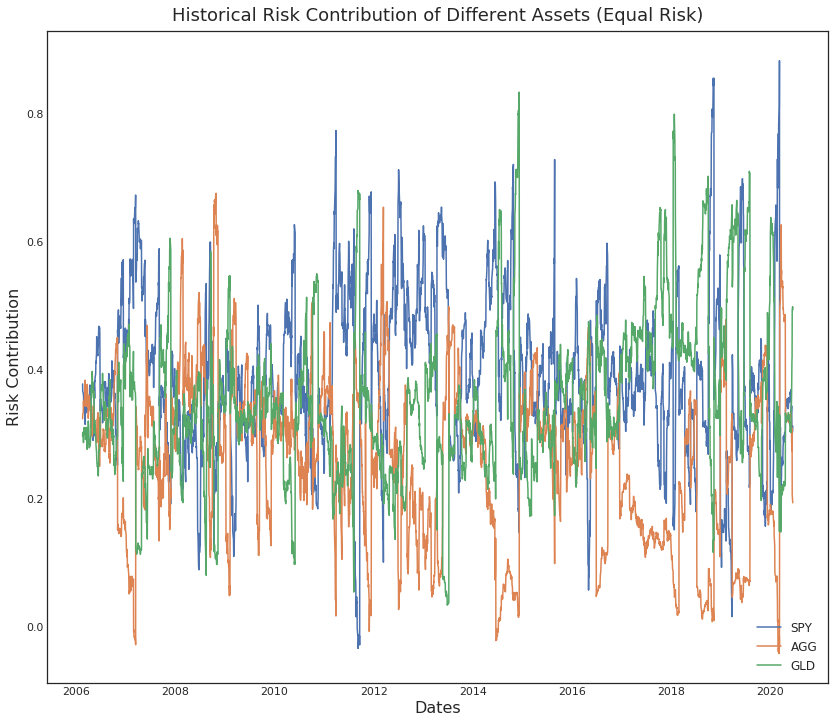

In [23]:
fig =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(risk_contribution)

title_text_obj = plt.title("Historical Risk Contribution of Different Assets (Equal Risk)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Risk Contribution', fontsize = 16)
ax.legend(('SPY', 'AGG', 'GLD'),fontsize = 12, loc='lower right')


plt.show()

In [24]:
backtest_level4, risk_contribution4, backtest_weight4 = Backtest(cov_frequency=60, rebalance_frequency=1, 
                                         method = "Equal Risk",get_records=True)

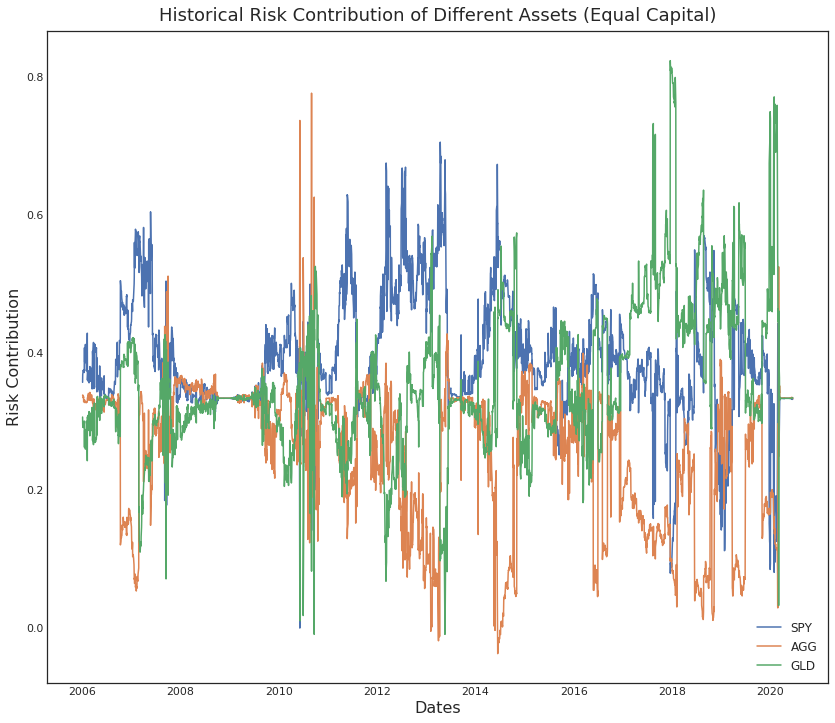

In [25]:
fig17 =plt.figure(figsize=outputsize)
ax = plt.gca()
ax.plot(risk_contribution4)

title_text_obj = plt.title("Historical Risk Contribution of Different Assets (Equal Capital)", fontsize = 18,
                          verticalalignment = 'bottom')

xlabel_obj = plt.xlabel('Dates', fontsize = 16)
ylabel_obj = plt.ylabel('Risk Contribution', fontsize = 16)
ax.legend(('SPY', 'AGG', 'GLD'),fontsize = 12, loc='lower right')


plt.show()